In [3]:
from pandas_datareader.data import Options
from dateutil.parser import parse
import datetime
from numpy import *
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.colors import LogNorm
#from implied_vol import BlackScholes
from functools import partial
from scipy import optimize
import numpy as np
from scipy.interpolate import griddata
import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like # Due to version difference
import pandas_datareader.data as web
import yfinance as yf
from scipy.interpolate import CubicSpline
from scipy.optimize import brentq
from scipy.optimize import minimize
from scipy.optimize import fmin
from scipy.stats import norm

In [2]:
import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like # Due to version difference
import pandas_datareader.data as web

# Set Up

In [4]:
# Change Company here 
ticker = '^SPX'
# Make it ticker object
comp = yf.Ticker(ticker)

In [5]:
# Stock Prices from Yahoo Finance
S = comp.history().iloc[-1,3] # Get current stock price for later #(start = start, end = end)

# # US libor rates effective from the 25/08/2021 - hardcoded directly from website
# rOvernight = 0.0008563
# rWeek = 0.0008788
# rMonth = 0.0009313
# r2Month = 0.0012175
# r3Month = 0.0012613
# r6Month = 0.0015150
# rYear = 0.0024325 

rOvernight = 0.0007575
rWeek = 0.0008413
rMonth = 0.0008463 
r2Month = 0.0009863 
r3Month = 0.0012075 
r6Month = 0.0015788 
rYear = 0.0023538  


time = np.array([1/365, 1/52, 1/12, 1/6, 1/4, 1/2, 1]) # time i.e. 1 week = 1/52, 1 month = 1/12
r = np.array( [rOvernight, rWeek, rMonth, r2Month, r3Month, r6Month, rYear]) # Libor rates put into an array
#Instantaneous rate 

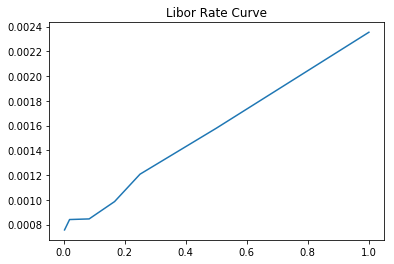

In [6]:
plt.plot(time,r)
plt.title("Libor Rate Curve")
plt.show()

In [7]:
# US Treasury Bills
from pandas_datareader.data import DataReader as dr
syms = ['DGS1MO', 'DGS3MO', 'DGS6MO', 'DGS1', 'DGS2', 'DGS3', 'DGS5']
yc = dr(syms, 'fred') # could specify start date with start param here
names = dict(zip(syms, ['1m', '3m', '6m', '1yr', '2yr', '3yr','5yr']))
yc = yc.rename(columns=names)
yc = yc[['1m', '3m', '6m','1yr', '2yr', '3yr', '5yr']]

USr = yc.iloc[-1,:].to_numpy()/100
r =  np.insert(r,len(r),USr[4]) # Adding US 2 year rate so we can linear interpolate later
r =  np.insert(r,len(r),USr[5]) # Adding US 3 year rate so we can linear interpolate later
r =  np.insert(r,len(r),USr[6]) # Adding US 5 year rate so we can linear interpolate later
time = np.insert(time, len(time), 2)
time = np.insert(time, len(time), 3)
time = np.insert(time, len(time), 5)

In [8]:
# Get expiries of available option prices
expiries = sorted(comp.options)

# Get Current Date and time to maturity (TTM)
CurrentDate = datetime.datetime.today()
ttm = np.ones(len(expiries))

#Converting expiry to TTM (Time to Maturity)
for i in range(len(expiries)):
        t = datetime.datetime.strptime(expiries[i], '%Y-%m-%d') - CurrentDate
        ttm[i] = t.days/365

In [9]:
# Interpolate r to the ttm we need (Linear Interpolation)
rNewi = np.interp(ttm, time, r) # These are interest rates we need

# Interpolate r to the ttm we need (Cubic Interpolation)
f = CubicSpline(time, r, bc_type="natural")
rNew = f(ttm) # These are interest rates we need

print("Libor time \n",time)
print("Yahoo Time to Maturity \n", ttm)
print("Libor r \n", r)
print("Yahoo rNew \n", rNew)
print("Yahoo rNew \n", rNewi)

Libor time 
 [2.73972603e-03 1.92307692e-02 8.33333333e-02 1.66666667e-01
 2.50000000e-01 5.00000000e-01 1.00000000e+00 2.00000000e+00
 3.00000000e+00 5.00000000e+00]
Yahoo Time to Maturity 
 [-2.73972603e-03  2.73972603e-03  8.21917808e-03  1.64383562e-02
  2.19178082e-02  2.73972603e-02  3.56164384e-02  4.10958904e-02
  4.38356164e-02  4.65753425e-02  5.47945205e-02  6.02739726e-02
  6.57534247e-02  7.39726027e-02  8.49315068e-02  1.04109589e-01
  1.23287671e-01  1.42465753e-01  1.80821918e-01  2.10958904e-01
  2.57534247e-01  2.95890411e-01  3.53424658e-01  3.80821918e-01
  4.30136986e-01  4.57534247e-01  5.06849315e-01  5.42465753e-01
  5.80821918e-01  6.79452055e-01  7.56164384e-01  7.91780822e-01
  8.32876712e-01  9.28767123e-01  1.00547945e+00  1.25479452e+00
  1.35068493e+00  1.75342466e+00  2.25205479e+00  4.51506849e+00]
Libor r 
 [0.0007575 0.0008413 0.0008463 0.0009863 0.0012075 0.0015788 0.0023538
 0.0023    0.0043    0.0079   ]
Yahoo rNew 
 [0.00072674 0.0007575  0.000788

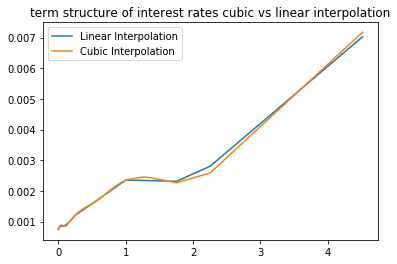

In [10]:
#Plot of interpolated interest rate term
plt.plot(ttm, rNewi,label="Linear Interpolation")
plt.plot(ttm, rNew,label ="Cubic Interpolation")
plt.legend()
plt.title("term structure of interest rates cubic vs linear interpolation")
plt.show()

# Black Scholes and Implied Volatility Models Used:

In [11]:
def bs(S, K, T, r, sigma,option="call"):
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call = S * norm.cdf(d1) - np.exp(-r * T) * K * norm.cdf(d2)
    put = call + ( np.exp(-r * T) * K ) - S
    if option == "call":
        return call
    elif option == "put":
        return put

def bs_vega(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    return S * norm.pdf(d1) * np.sqrt(T)

#ONLY NEWTON RAPHSON
def impliedVol(target, S, K, T, r, sigma=0.5, option ="call", tol=0.0001, max_iterations=100):
    '''
    :param C: Observed call price
    :param S: Asset price
    :param K: Strike Price
    :param T: Time to Maturity
    :param r: riskfree rate
    :param tol: error tolerance in result
    :param max_iterations: max iterations to update vol
    :return: implied volatility in percent
    '''

    for i in range(max_iterations):

        ### calculate difference between blackscholes price and market price with
        ### iteratively updated volality estimate
        diff = bs(S, K, T, r, sigma, option) - target

        ###break if difference is less than specified tolerance level
        if abs(diff) < tol:
            print("found on {}th iteration".format(i))
            print("difference is equal to {}\n".format(diff))
            break

        ### use newton rapshon to update the estimate
#         print(bs_vega(S, K, T, r, sigma))
        sigma = sigma - diff / bs_vega(S, K, T, r, sigma)
#         print(sigma)
    return sigma

In [12]:
def ivVer2(target, S, K, T, r, sigma=0.5, option ="call", tol=0.000001, max_iterations=100,tune_limit = 10):
    '''
    :param C: Observed call price
    :param S: Asset price
    :param K: Strike Price
    :param T: Time to Maturity
    :param r: riskfree rate
    :param tol: error tolerance in result
    :param max_iterations: max iterations to update vol
    :return: implied volatility in percent
    '''
    sigma0=sigma #placeholder for initial value in case of nan
#     a = 0.0001   #lower_bound 
#     b = 1       #upper_bound
    count = 0
    while count < (max_iterations):

        ### calculate difference between blackscholes price and market price with
        ### iteratively updated volality estimate
        diff = bs(S, K, T, r, sigma, option) - target

        ###break if difference is less than specified tolerance level
        if abs(diff) < tol:
#             print("found on {}th iteration".format(i))
#             print("target price difference is equal to {}\n".format(diff))
            break

        ### use newton rapshon to update the estimate
        sigma = sigma - diff / bs_vega(S, K, T, r, sigma)
        
        
        ## Bisection kicks in to deal with nans 

        if (np.isnan(sigma)==True):
            tune = 0.05 # Need starting tune
            a = sigma0-tune
            b = sigma0+tune
            
#             if a < 0:    #prevent lower bound to be negative
#                 a = 0.00000000000000000001
            sigma = sigma0 
            count = 0      #restarts calculations
            # If solution exists, it will return here


            diff1 = bs(S, K, T, r, a, option) - target
            diff2 = bs(S, K, T, r, b, option) - target
            
            # possibility of double or more roots or no root in interval
            # Deal with possibility of no roots (Increase Interval)
            tune1 = 0.01
            while (diff1*diff2>0) and (tune1<tune_limit):
                
                tune1 += 0.05 #Increasing from both sides
                a1 = sigma0 - tune1
#                 if a1 < 0:
#                     a1 = 0.00000000000000000001
                b1 = sigma0 + tune1
                diff2 = bs(S, K, T, r, b1, option) - target
                diff1 = bs(S, K, T, r, a1, option) - target
                if (diff1*diff2 < 0):  
                    b = b1
                    a = a1
                    print("hallelujah1")
            
            # Lets deal with possibility of double root here (Decrease Interval)
            tester = 1
            tester_limit = 50
            gridcheck = np.linspace(0,b-a,tester_limit)
            for i in gridcheck:
                difftest = bs(S, K, T, r, a+i, option) - target
                while ((diff1*difftest < 0) and (diff2*difftest < 0) and (tester < tester_limit)): 
                    print("case2 started")
                    length = b-a 
                    bnew = b * (1 - (length)*(tester/tester_limit)) #decrease interval 2% each time from RHS
                    diff2 = bs(S, K, T, r, bnew, option) - target
                    tester+=1
                    if (((diff1*difftest > 0) and (diff2*difftest < 0)) or ((diff1*difftest < 0) and (diff2*difftest > 0)))  :  
                        b = bnew   
#                         difftest = bs(S, K, T, r, (a+b)/2, option) - target
                        print("hallelujah2")

            
            if diff1*diff2 >0:
                print("FAILED")
                return np.nan
            
            while count < (max_iterations):
                    # Only Bisection
                    diff = bs(S, K, T, r, sigma, option) - target
                    diff1 = bs(S, K, T, r, a, option) - target
                    
                    if abs(diff) < tol:
                        print("BOO    \n  found on {}th iteration".format(i))
                        print("BOO      target price difference is equal to {}\n".format(diff))
                        return sigma   
                    if diff1*diff > 0: 
                        a = max(sigma,a)
                    elif diff1*diff < 0:
                        b = min(sigma,b)
                    if abs(b - a) < 0.00000001: # Interval of vol estimates almost equal (x's)
                        print("volatility estimates converged")
                        return sigma
                    
                    sigma = a + (b-a)/2   # mid vol for next iteration if no tolerance criteria broken

                    # THIS IS THE HYBRID PART - USE LATER
#                     if ((sigma1 - diff / bs_vega(S, K, T, r, sigma1)) < b) or ((sigma1 - diff / bs_vega(S, K, T, r, sigma1)) > a):
#                         sigma= (sigma1 - diff / bs_vega(S, K, T, r, sigma1))
#                     else:
#                         sigma = sigma1

                    count += 1
    
     
                    
#                     print("Sigma: {}\n a: {}\n b: {}\n tune: {}\n".format(sigma,a,b,tune1))    
            return sigma # If solution exists or not, it will resturn here
            # if solution does not exist = tried different starting points and bounded between a and b not working
                    
        count += 1
    return sigma

In [13]:
def brentm(target, S, K, T, r, sigma=0.5, option ="call", tol=0.000001, max_iterations=100,tune_limit = 0.4):

        sigma0=sigma
        tune = .5 # Need starting tune
        a = sigma0-tune
        b= sigma0+tune
#         if a <0:
#             a=0.00001
        diff1 = bs(S, K, T, r, a, option) - target
        diff2 = bs(S, K, T, r, b, option) - target
    
        
        while (diff1*diff2>0) and (tune<tune_limit):
                    tune += .1 #Increasing from both sides
                    a = sigma - tune
#                     if a<0:
#                         a =0.00000000000000000001
                    b = sigma + tune
                    diff1 = bs(S, K, T, r, a, option) - target
                    diff2 = bs(S, K, T, r, b, option) - target
        
        tester = 0
        testlimit =100
        gridcheck = np.linspace(0,b-a,testlimit)
        for i in gridcheck:
                difftest = bs(S, K, T, r, a+i, option) - target
                while ((diff1*difftest < 0) and (diff2*difftest < 0) and (tester < testlimit)): 
                            length = b-a 
                            bnew = b * (1 - (length)*(tester/tester_limit)) #decrease interval 2% each time from RHS
                            diff2 = bs(S, K, T, r, bnew, option) - target
                            tester+=1
                            if (((diff1*difftest > 0) and (diff2*difftest < 0)) or ((diff1*difftest < 0) and (diff2*difftest > 0)))  :  
                                b = bnew   
        #                         difftest = bs(S, K, T, r, (a+b)/2, option) - target
                                print("hallelujah2")

        def bs_1(vol):
            return bs(S, K, T, r, vol, option) - target
        
        return brentq(bs_1,a,b,maxiter=max_iterations,disp=False)

In [14]:
# Rational Approximation Parameters from Li (2006)
n = np.zeros((5,5))
m = np.zeros((5,5))
n[0,1] = -0.068098378725
n[1,0] = 0.440639436211
n[0,2] = -0.263473754689
n[1,1] = -5.792537721792
n[2,0] = -5.267481008429
n[0,3] = 4.714393825758
n[1,2] = 3.529944137559
n[2,1] = -23.636495876611
n[3,0] = -9.020361771283
n[0,4] = 14.749084301452
n[1,3] = -32.570660102526
n[2,2] = 76.398155779133
n[3,1] = 41.855161781749
n[4,0] = -12.150611865704

m[0,1] = 6.268456292246
m[1,0] = -6.284840445036
m[0,2] = 30.068281276567
m[1,1] = -11.780036995036
m[2,0] = -2.310966989723
m[0,3] = -11.473184324152
m[1,2] = -230.101682610568 
m[2,1] = 86.127219899668
m[3,0] = 3.730181294225
m[0,4] = -13.954993561151
m[1,3] = 261.950288864225
m[2,2] = 20.090690444187
m[3,1]= -50.117067019539
m[4,0] = 13.723711519422
p1 =  -0.969271876255
p2 =  0.097428338274
p3 =  1.750081126685


In [15]:
# First we get observed normalised call price
def normc(option_price,S):
    return option_price / S

# theoretical_normalised_c
def theoretical_normalised_c(x,v):
    return norm.cdf((x/v) + (v/2)) - np.exp(-x)*norm.cdf((x/v) - (v/2))  

# Moneyness
def x(S,K,r,ttm):
    return np.log(S*np.exp(r*ttm)/K)

def domainD_check(observed_moneyness,observed_normalised_c):
    check1 = 0
    check2 = 0
    if (observed_moneyness >= 0):
        observed_moneyness = -observed_moneyness
        observed_normalised_c = np.exp(-observed_moneyness)*observed_normalised_c + 1 - np.exp(-observed_moneyness)
        
    if (observed_normalised_c <= theoretical_normalised_c(observed_moneyness,(observed_moneyness)/2)):
        #Newton Raphson here if this is broken - rare
        
        print("FLAG")
    return observed_moneyness, observed_normalised_c

def rationalApprox_v1(moneyness,c,p1,p2,p3,m,n): 
    
    collection1 = 0
    collection2 = 1
    for i in range(0,len(n)):
        for j in range(0,len(m)):
            if ((i + j)>=1) and ((i + j)<=4):
                temp1 = n[i,j] * (moneyness**(i)) * (np.sqrt(abs(c))**(j))
                temp2 = m[i,j] * (moneyness**(i)) * (np.sqrt(abs(c))**(j))
                collection1 += temp1
                collection2 += temp2

    return p1*moneyness + p2*np.sqrt(abs(c)) + p3*c + ((collection1)/(collection2))

In [16]:
# Volatility Bounds
#Normalised call price
def normc(option_price,S):
    return option_price / S

# Moneyness
def Kmoneyness(S,K,r,ttm):
    return np.log(K/(S*np.exp(r*ttm)))

def bounds(normalised_c,moneyness,ttm):
    upper = (-2/np.sqrt(ttm))*norm.ppf((1-normalised_c)/(1+np.exp(moneyness)))
    if moneyness >=0:
        lower = (-2/np.sqrt(ttm))*norm.ppf((1-normalised_c)/(2))
    elif moneyness < 0:
        lower = (-2/np.sqrt(ttm))*norm.ppf((1-normalised_c)/(2*np.exp(moneyness)))
    return upper, lower
        
def vol_calc(obs_price,S,K,T,r):
    ep=0.1
    
    moneyness = Kmoneyness(S,K,r,T)
    normalised_c = normc(obs_price,S)
    upper, lower = bounds(normalised_c,moneyness,T)
    dv = 1/50
    spaces=np.linspace(lower,upper,int(1/dv))
    term2 = 0
    vol = 0
    while ((vol<lower) or (vol>upper)) and (ep<10e10):
        term1 = (S*np.sqrt(T)) / (2*np.sqrt(2*(1/ep))*np.pi)
        for i in spaces:
    #         dplus = (-moneyness/(i*np.sqrt(T))) + ((i*np.sqrt(T))/2)
    #         dminus = (-moneyness/(i*np.sqrt(T))) - ((i*np.sqrt(T))/2 )
            d1 = (np.log(S/K) + (r + 0.5*i**2)*T) / (i*np.sqrt(T))
            exponent=np.exp(((- (bs(S, K, T, r, i, option="call") - obs_price)**(2) )/(4*(1/ep))) - (d1**(2)/2))
            term2 += dv*i*exponent
        vol = term1*term2
        ep*=10
    if vol == 0:
        vol = (upper+lower)/2

    return vol

# Volatility Surfaces:


Select which IV to test:

In [17]:
model = 4

# 1 : Newton and Bisection
# 2 : Brent-Dekker
# 3 : Rational approximation
# 4 : Dirac Delta Closed form approximation


In [28]:
# Make strikes grid
maxStrike = np.zeros(len(expiries))
minStrike = np.zeros(len(expiries))
for i in range(0,len(expiries)):
    maxStrike[i] = comp.option_chain(expiries[i]).calls.iloc[:,2].max()
    minStrike[i] = comp.option_chain(expiries[i]).calls.iloc[:,2].min()
ind1 = np.where(~np.isnan(maxStrike))
ind2 = np.where(~np.isnan(minStrike))
overallMax = maxStrike[ind1].max()
overallMin = minStrike[ind2].min()

In [29]:
NewStrike = np.arange(overallMin, overallMax + 1)
print(overallMax, overallMin)

7600.0 100.0


In [30]:
from datetime import datetime
today = datetime.today().date()
maturityDates = np.zeros(len(expiries))
for i in range(len(expiries)):
    t = datetime.strptime(expiries[i], '%Y-%m-%d').date() - today
    maturityDates[i] = t.days/365
maturityDates

array([0.        , 0.00547945, 0.0109589 , 0.01917808, 0.02465753,
       0.03013699, 0.03835616, 0.04383562, 0.04657534, 0.04931507,
       0.05753425, 0.0630137 , 0.06849315, 0.07671233, 0.08767123,
       0.10684932, 0.1260274 , 0.14520548, 0.18356164, 0.21369863,
       0.26027397, 0.29863014, 0.35616438, 0.38356164, 0.43287671,
       0.46027397, 0.50958904, 0.54520548, 0.58356164, 0.68219178,
       0.75890411, 0.79452055, 0.83561644, 0.93150685, 1.00821918,
       1.25753425, 1.35342466, 1.75616438, 2.25479452])

In [23]:
# Check if len(x)>0:
for i in range(0,len(expiries)):
    x = comp.option_chain(expiries[i]).calls.iloc[:,2]
    x = x[x.between(overallMin, overallMax)]
    if len(x)<2:
        print(i)

39


In [21]:
len(expiries)

40

In [25]:
expiries

['2021-09-13',
 '2021-09-15',
 '2021-09-17',
 '2021-09-20',
 '2021-09-22',
 '2021-09-24',
 '2021-09-27',
 '2021-09-29',
 '2021-09-30',
 '2021-10-01',
 '2021-10-04',
 '2021-10-06',
 '2021-10-08',
 '2021-10-11',
 '2021-10-15',
 '2021-10-22',
 '2021-10-29',
 '2021-11-05',
 '2021-11-19',
 '2021-11-30',
 '2021-12-17',
 '2021-12-31',
 '2022-01-21',
 '2022-01-31',
 '2022-02-18',
 '2022-02-28',
 '2022-03-18',
 '2022-03-31',
 '2022-04-14',
 '2022-05-20',
 '2022-06-17',
 '2022-06-30',
 '2022-07-15',
 '2022-08-19',
 '2022-09-16',
 '2022-12-16',
 '2023-01-20',
 '2023-06-16',
 '2023-12-15']

In [24]:
expiries = expiries[0:39]
# Add a check for expiries

In [26]:
BS_DF = pd.DataFrame(columns=expiries)
#Loop Through expiries and interest rate
for i in range(len(expiries)):
    timeNew = np.sort(np.append(time, maturityDates[i])) 
    rNew = np.interp(timeNew, time, r) # interpolate interest rates to find the interest rate for our maturity date
    rOption = rNew[np.where(timeNew == maturityDates[i])]
    x = comp.option_chain(expiries[i]).calls.iloc[:,2]
    x = x[x.between(overallMin, overallMax)]
    if len(x)<2:
        break
    ind = x.index
    y = comp.option_chain(expiries[i]).calls.iloc[ind,3] #Prices of the options
    BS_IV = np.ones(len(x)) #Initialise implied vol
    impvol = comp.option_chain(expiries[i]).calls.iloc[ind,10] #Yahoo volaitlity
    
    #Loop through prices, strikes for given interest rate and expiry
    for j in range(0,len(x)):
        if maturityDates[i] == 0:
            maturityDates[i] = 0.0001
        sigma1=np.sqrt((2*np.pi)/maturityDates[i])*(y.iloc[j]/S) #Brenners initial closed form sigma estimate
        if model == 1:
            BS_IV[j] = ivVer2(target=y.iloc[j], S=S, K=x.iloc[j], T=maturityDates[i], r=rOption[0], sigma=sigma1, option ="call", tol=0.000001, max_iterations=100,tune_limit = 10)       
        if model == 2:
            BS_IV[j] = brentm(target=y.iloc[j], S=S, K=x.iloc[j], T=maturityDates[i], r=rOption[0], sigma=0.5, option ="call", tol=0.000001, max_iterations=100,tune_limit = 20)
        if model == 3:
            BS_IV[j] = rationalApprox_v1(moneyness=Kmoneyness(S=S,K=x.iloc[j],r=rOption[0],ttm=maturityDates[i]),c=normc(option_price=y.loc[j],S=S),p1=p1,p2=p2,p3=p3,m=m,n=n)
        if model == 4:
            BS_IV[j] = vol_calc(obs_price=y.iloc[j],S=S,K=x.iloc[j],T=maturityDates[i],r=rOption[0])
            
        if (np.isnan(BS_IV[j]) == True) or (np.isinf(BS_IV[j])==True):
                sigma1=np.sqrt((2*np.pi)/maturityDates[i])*y.iloc[j]/S
                BS_IV[j] = sigma1
        if (BS_IV[j]>1):
            BS_IV[j] = 1 #Cap really big implied vols at 1 - only need for maturity date = 0
        if (BS_IV[j]<0.0001):
            BS_IV[j] = 0 #Cap really big implied vols at 1 - only need for maturity date = 0
            
#     x = x[~np.isinf(BS_IV)]
#     BS_IV = BS_IV[~np.isinf(BS_IV)]
#     x = x[~np.isnan(BS_IV)]
#     BS_IV = BS_IV[~np.isnan(BS_IV)]
#     BS_IV[0]=BS_IV[1]
#     BS_IV[len(BS_IV)-1]=BS_IV[len(BS_IV)-2]
    BS_IV = np.interp(NewStrike, x.to_numpy(), BS_IV)
#     BS_spline = CubicSpline(x.to_numpy(), BS_IV, bc_type='natural')
#     BS_IV = BS_spline(NewStrike)
    for ix in range(0,len(BS_IV)):
#         if BS_IV[ix] >1 :
#             BS_IV[ix] = 1
        if BS_IV[ix] < 0:
            BS_IV[ix] = 0
        if BS_IV[ix] > 1:
            BS_IV[ix] = 1
   
    
            
    BS_DF[expiries[i]] = BS_IV
BS_DF = BS_DF.set_index(NewStrike)

C:\Users\arinj\AppData\Local\Enthought\Canopy\edm\envs\User\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\arinj\AppData\Local\Enthought\Canopy\edm\envs\User\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\arinj\AppData\Local\Enthought\Canopy\edm\envs\User\lib\site-packages\scipy\stats\_distn_infrastructure.py:1827: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= np.asarray(_b)) & cond0


In [ ]:
for i in range(0,len(expiries)):
    x = comp.option_chain(expiries[i]).calls.iloc[:,2]
    x = x[x.between(overallMin, overallMax)]
    print(len(x))
    if len(x)<2:
        print("stop",i)

In [ ]:
len(expiries)

In [ ]:
# x = comp.option_chain(expiries[37]).calls.iloc[:,2]
# x = x[x.between(overallMin, overallMax)]
maturityDates

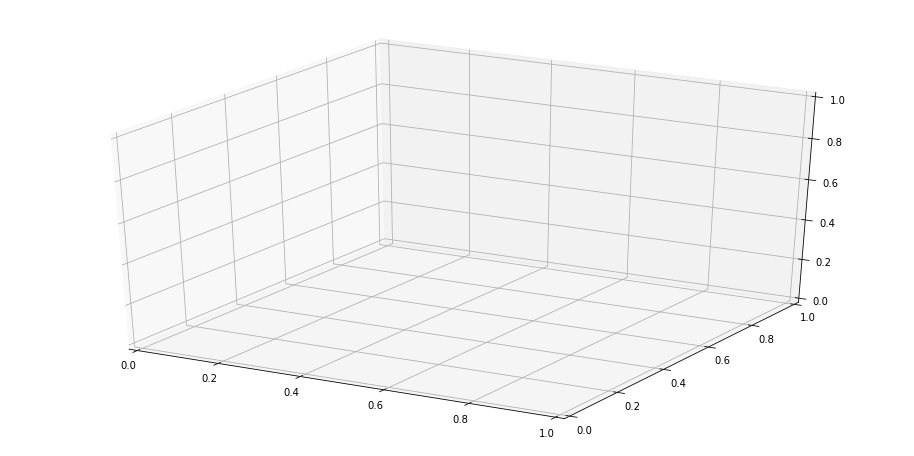

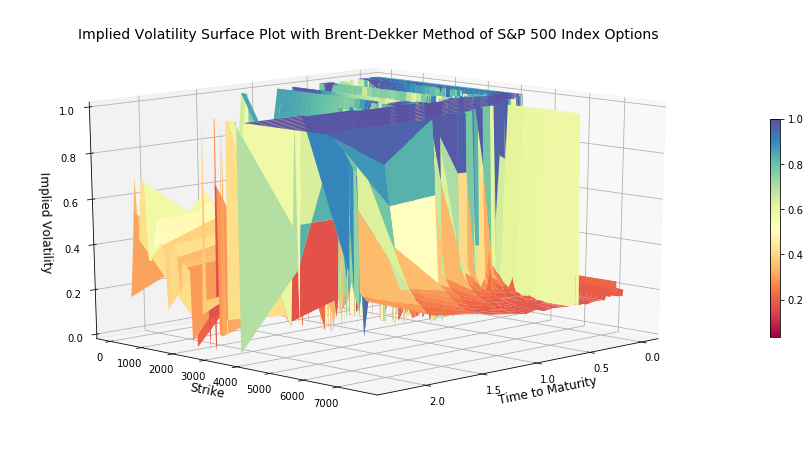

In [31]:
BS_np = BS_DF.to_numpy()
# 3D surface plot of matrix V
fig = plt.figure(figsize = (16, 8))
ax = plt.axes(projection='3d')
X, Y =np.meshgrid(maturityDates, NewStrike)
s = ax.plot_surface(X, Y, BS_np, cmap = 'Spectral')
ax.set_xlabel('Time to Maturity', fontsize=12)
ax.set_ylabel('Strike', fontsize=12)
ax.set_zlabel('Implied Volatility', fontsize=12)
ax.set_title('Implied Volatility Surface Plot with Brent-Dekker Method of S&P 500 Index Options', fontsize=14)
# ax.set_zlim3d(0,1)
fig.colorbar(s, shrink=0.5, aspect=20)
ax.view_init(15,45)
plt.show()

In [22]:
# BS_DF.to_csv("Implied_Vol_Surface.csv")

In [90]:
yahoo_IV = pd.DataFrame(columns=expiries)
for i in range(len(expiries)):
#     yahoo_IV[Maturity[i]] = np.interp(NewStrike, tsla.option_chain(Maturity[i]).calls.iloc[:,2],
#                                      tsla.option_chain(Maturity[i]).calls.iloc[:,10])
    YahooSpline = CubicSpline(comp.option_chain(expiries[i]).calls.iloc[:,2],
                                       comp.option_chain(expiries[i]).calls.iloc[:,10], bc_type='natural')
    yahoo_IV[expiries[i]] = YahooSpline(NewStrike)
yahoo_IV.set_index(NewStrike) 

,2021-08-31,2021-09-01,2021-09-03,2021-09-07,2021-09-08,2021-09-10,2021-09-13,2021-09-15,2021-09-17,2021-09-20,...,2022-05-20,2022-06-17,2022-06-30,2022-07-15,2022-08-19,2022-09-16,2022-12-16,2023-01-20,2023-06-16,2023-12-15
100.0,69.364707,239.321831,5.054720,16153.855253,426.349392,978.569970,23.347137,45.377047,0.000010,-23.034048,...,0.000351,0.000010,-1300.105399,0.012256,-16.297969,-0.070209,0.000010,7.603838,-0.000107,0.000010
101.0,69.213330,239.111064,5.054731,16140.197880,425.997147,977.574476,23.328574,45.337452,0.078925,-23.013464,...,0.000346,0.000010,-1298.986358,0.012358,-16.282032,-0.070072,0.000010,7.592965,-0.000106,0.000010
102.0,69.062181,238.900422,5.054740,16126.548204,425.645096,976.579657,23.310022,45.297880,0.157822,-22.992891,...,0.000341,0.000010,-1297.867957,0.012460,-16.266104,-0.069935,0.000010,7.582101,-0.000106,0.000010
103.0,68.911259,238.689904,5.054749,16112.906223,425.293239,975.585514,23.291481,45.258331,0.236684,-22.972330,...,0.000336,0.000010,-1296.750198,0.012562,-16.250187,-0.069798,0.000010,7.571248,-0.000105,0.000010
104.0,68.760565,238.479510,5.054756,16099.271935,424.941577,974.592046,23.272950,45.218806,0.315493,-22.951780,...,0.000331,0.000010,-1295.633078,0.012663,-16.234280,-0.069661,0.000010,7.560405,-0.000105,0.000010
105.0,68.610097,238.269240,5.054762,16085.645338,424.590109,973.599252,23.254430,45.179305,0.394231,-22.931243,...,0.000326,0.000010,-1294.516599,0.012763,-16.218383,-0.069524,0.000010,7.549573,-0.000104,0.000010
106.0,68.459857,238.059094,5.054767,16072.026430,424.238835,972.607133,23.235920,45.139827,0.472881,-22.910717,...,0.000321,0.000010,-1293.400760,0.012864,-16.202496,-0.069387,0.000010,7.538751,-0.000104,0.000010
107.0,68.309844,237.849073,5.054770,16058.415208,423.887755,971.615689,23.217421,45.100372,0.551424,-22.890202,...,0.000316,0.000010,-1292.285561,0.012964,-16.186620,-0.069250,0.000010,7.527939,-0.000103,0.000010
108.0,68.160057,237.639176,5.054773,16044.811670,423.536869,970.624918,23.198932,45.060941,0.629844,-22.869700,...,0.000311,0.000010,-1291.171001,0.013063,-16.170754,-0.069113,0.000010,7.517137,-0.000103,0.000010
109.0,68.010497,237.429402,5.054774,16031.215814,423.186177,969.634822,23.180454,45.021533,0.708123,-22.849209,...,0.000306,0.000010,-1290.057081,0.013162,-16.154898,-0.068976,0.000010,7.506346,-0.000102,0.000010


In [94]:
BS_DF

,2021-09-13,2021-09-15,2021-09-17,2021-09-20,2021-09-22,2021-09-24,2021-09-27,2021-09-29,2021-09-30,2021-10-01,...,2022-05-20,2022-06-17,2022-06-30,2022-07-15,2022-08-19,2022-09-16,2022-12-16,2023-01-20,2023-06-16,2023-12-15
100.0,1.000000,1.00000,1.000000,0.671954,0.804065,0.954370,0.455532,0.893786,1.000000,0.758817,...,0.000000,0.000000,0.159795,0.000000,0.205088,0.000000,0.000000,0.000000,0.000000,0.000000
101.0,1.000000,1.00000,1.000000,0.671954,0.804065,0.954370,0.455532,0.893786,1.000000,0.758817,...,0.000000,0.000000,0.159795,0.000000,0.205088,0.000000,0.000000,0.000000,0.000000,0.000000
102.0,1.000000,1.00000,1.000000,0.671954,0.804065,0.954370,0.455532,0.893786,1.000000,0.758817,...,0.000000,0.000000,0.159795,0.000000,0.205088,0.000000,0.000000,0.000000,0.000000,0.000000
103.0,1.000000,1.00000,1.000000,0.671954,0.804065,0.954370,0.455532,0.893786,1.000000,0.758817,...,0.000000,0.000000,0.159795,0.000000,0.205088,0.000000,0.000000,0.000000,0.000000,0.000000
104.0,1.000000,1.00000,1.000000,0.671954,0.804065,0.954370,0.455532,0.893786,1.000000,0.758817,...,0.000000,0.000000,0.159795,0.000000,0.205088,0.000000,0.000000,0.000000,0.000000,0.000000
105.0,1.000000,1.00000,1.000000,0.671954,0.804065,0.954370,0.455532,0.893786,1.000000,0.758817,...,0.000000,0.000000,0.159795,0.000000,0.205088,0.000000,0.000000,0.000000,0.000000,0.000000
106.0,1.000000,1.00000,1.000000,0.671954,0.804065,0.954370,0.455532,0.893786,1.000000,0.758817,...,0.000000,0.000000,0.159795,0.000000,0.205088,0.000000,0.000000,0.000000,0.000000,0.000000
107.0,1.000000,1.00000,1.000000,0.671954,0.804065,0.954370,0.455532,0.893786,1.000000,0.758817,...,0.000000,0.000000,0.159795,0.000000,0.205088,0.000000,0.000000,0.000000,0.000000,0.000000
108.0,1.000000,1.00000,1.000000,0.671954,0.804065,0.954370,0.455532,0.893786,1.000000,0.758817,...,0.000000,0.000000,0.159795,0.000000,0.205088,0.000000,0.000000,0.000000,0.000000,0.000000
109.0,1.000000,1.00000,1.000000,0.671954,0.804065,0.954370,0.455532,0.893786,1.000000,0.758817,...,0.000000,0.000000,0.159795,0.000000,0.205088,0.000000,0.000000,0.000000,0.000000,0.000000
